<link rel="stylesheet" href="/site-assets/css/style.css">
<link rel="stylesheet" href="/site-assets/css/gemma.css">


##### Copyright 2024 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fine-tune PaliGemma with JAX and Flax

<table class="tfo-notebook-buttons" align="left">
<td>
<a target="_blank" href="https://ai.google.dev/gemma/docs/paligemma/fine-tuning-paligemma"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on ai.google.dev</a>
</td>
<td>
<a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemma/docs/paligemma/fine-tuning-paligemma.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>
<td>
<a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/gemma/docs/paligemma/fine-tuning-paligemma.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td>
</table>

This notebook shows how to fine-tune [PaliGemma](https://ai.google.dev/gemma/docs/paligemma) on a vision-language task with [JAX](https://jax.readthedocs.io/en/latest/index.html). *Fine-tuning* is a process that can improve your model's performance on specific tasks or help the model adhere to specific output requirements when instructions aren't sufficient and you have a set of examples that demonstrate the outputs you want. Gemma-based models like PaliGemma require fine-tuning to produce expected results.

### What's in this notebook

This notebook uses the model reference implementation from [`big_vision`](https://github.com/google-research/big_vision)
and shows how to:

 * Install dependencies, and download the PaliGemma model checkpoint and training data
 * Load the model onto GPU devices
 * Prepare the model's inputs for training and inference
 * Fine-tune the model
 * Inspect the output

The training data for this notebook consists of 90 pairs of images and long captions describing them. To make it runnable on a T4 colab runtime, you'll only fine-tune the attention layers of the language model and freeze the other parameters.

This example is for learning purposes only. In a real use case, the amount of data, trainable parameters, training steps and hyper-parameters, and obtained results could be significantly different.

### Before you begin

Before going through this notebook, you should be familiar with Python code, as well as how large language models (LLMs) are trained. You don't need to be familiar with JAX, but basic knowledge about JAX (or similar technologies such as Keras) is helpful when reading through the example code.

## Setup

The following sections explain the preliminary steps for getting a notebook to use a PaliGemma model, including model access, getting an API key, and configuring the notebook runtime.

### Get access to PaliGemma

Before using PaliGemma for the first time, you must request access to the model through Kaggle by completing the following steps:

1. Log in to [Kaggle](https://www.kaggle.com), or create a new Kaggle account if you don't already have one.
1. Go to the [PaliGemma model card](https://www.kaggle.com/models/google/paligemma-2) and click **Request Access**.
1. Complete the consent form and accept the terms and conditions.

### Configure your API key

To use PaliGemma, you must provide your Kaggle username and a Kaggle API key.

To generate a Kaggle API key, open your [**Settings** page in Kaggle](https://www.kaggle.com/settings) and click **Create New Token**. This triggers the download of a `kaggle.json` file containing your API credentials.

Then, in Colab, select **Secrets** (🔑) in the left pane and add your Kaggle username and Kaggle API key. Store your username under the name `KAGGLE_USERNAME` and your API key under the name `KAGGLE_KEY`.


### Select the runtime

To complete this tutorial, you'll need to have a Colab runtime with sufficient resources to run the PaliGemma model. In this case, you can use a T4 GPU:

1. In the upper-right of the Colab window, click the **▾ (Additional connection options)** dropdown menu.
1. Select **Change runtime type**.
1. Under **Hardware accelerator**, select **T4 GPU**.

### Set environment variables

Set the environment variables for `KAGGLE_USERNAME` and `KAGGLE_KEY`.

In [ ]:
import os
from google.colab import userdata

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate or make your credentials available in ~/.kaggle/kaggle.json

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

# The T4 runtime is tight on memory to finetune this model. Preallocate
# all memory ahead of time to avoid out-of-memory due to fragmentation.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"

### Fetch the `big_vision` repository and install related dependencies

Download the `big_vision` repository to your Colab notebook from GitHub and install dependencies related to `big_vision` by running the following code.

In [ ]:
import os
import sys

# TPUs with
if "COLAB_TPU_ADDR" in os.environ:
  raise "It seems you are using Colab with remote TPUs which is not supported."

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 5.6 MB/s eta 0:00:00


### Import JAX and other dependencies

Import JAX and other dependencies required for PaliGemma, like TensorFlow and NumPy.

In [ ]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image

from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import matplotlib.pyplot as plt

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.extend.backend.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.5.2
JAX platform: gpu
JAX devices:  1


## Download and configure the model

In this step, you'll download the model checkpoint and configure it so that you can fine-tune it later on. This step shows you how to move model parameters into TPU memory, which is useful for fine-tuning models on devices with limited resources.

### Download the model checkpoint

PaliGemma includes several model variations. For this tutorial, you'll use the base [JAX/FLAX PaliGemma 3B weight model](https://www.kaggle.com/models/google/paligemma-2/jax/paligemma2-3b-pt-224).

Download the model checkpoint from Kaggle by running the following code. This process takes several minutes to complete.

In [ ]:
import os
import kagglehub

# Use these for PaliGemma-2 3B 224px²
LLM_VARIANT = "gemma2_2b"
MODEL_PATH = "./paligemma2-3b-pt-224.b16.npz"
KAGGLE_HANDLE = "google/paligemma-2/jax/paligemma2-3b-pt-224"  # Path to fetch from Kaggle.

# Use these for PaliGemma 1:
# LLM_VARIANT = "gemma_2b"
# MODEL_PATH = "./paligemma-3b-pt-224.f16.npz"
# KAGGLE_HANDLE = "google/paligemma/jax/paligemma-3b-pt-224"

if not os.path.exists(MODEL_PATH):
  print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
  MODEL_PATH = kagglehub.model_download(KAGGLE_HANDLE, MODEL_PATH)
  print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
  print("Downloading the model tokenizer...")
  !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
  print(f"Tokenizer path: {TOKENIZER_PATH}")

DATA_DIR="./longcap100"
if not os.path.exists(DATA_DIR):
  print("Downloading the dataset...")
  !gsutil -m -q cp -n -r gs://longcap100/ .
  print(f"Data path: {DATA_DIR}")

100%|██████████| 5.65G/5.65G [06:19<00:00, 16.0MB/s]


Model path: /root/.cache/kagglehub/models/google/paligemma-2/jax/paligemma2-3b-pt-224/1/./paligemma2-3b-pt-224.b16.npz
Copying gs://big_vision/paligemma_tokenizer.model...
\ [1 files][  4.1 MiB/  4.1 MiB]                                                
Operation completed over 1 objects/4.1 MiB.                                      
Tokenizer path: ./paligemma_tokenizer.model
Data path: ./longcap100


### Configure the model

It's time to actually start configuring the model that you're going to use.

For this notebook, you need to be able to fit your model onto a T4 GPU. Having a limited resource like space constraints means that you have to be mindful of how your model is configured.

If you fine-tune every parameter, your model won't be able to run in the notebook environment. As a result, in this part of the notebook, you'll configure your model so that it has the ability to freeze some of the parameters, and only fine-tune the parameters that really need to be fine-tuned for the model to give you accurate results. In LLMs, parameters are said to be *frozen* when they are no longer actively being used to train the model.

In order to configure your model, you need to:

* Initialize the `model_config` as a [`FrozenConfigDict`](https://github.com/google/ml_collections/tree/master#frozenconfigdict) so that you can freeze some of the parameters and keep memory usage low
* Initialize an instance of the PaliGemma `Model` class using the `model_config` as its configurations
* Load the model parameters into RAM
* Define a `decode` function to sample outputs from the model

This code in this cell takes about a minute to run to completion.

In [ ]:
# Define model

# IMPORTANT: Gemma-2 has a "final_logits_softcap" property. Set it to 0.0
# for better transfer results.
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152, "variant": LLM_VARIANT, "final_logits_softcap": 0.0},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

### Move model parameters into GPU/TPU memory

Now you need to move the model parameters into GPU/TPU memory. First, shard the parameters across the available GPUs, then load the parameters. Here, you'll load the parameters sequentially. This process takes longer than loading them simultaneously, but it requires more RAM than you have available in this notebook.

Finally, print out all of the parameters to see what type each individual parameter is cast to. Frozen parameters are kept as `float16`, while the trainable parameters are cast to `float32`. When you inspect the list, you'll see that most of the parameters have been frozen and are `float16`.

In [ ]:
# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  # Cast others to float16, since some GPUs don't support bf16.
  return jax.tree.map(lambda p, m: p.astype(jnp.float32)
                      if m else p.astype(jnp.float16),
                      params, trainable)

# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default.
# Instead, do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

## Prepare to tune the model

Now that your model is configured, you can tune it. In this step, you'll create your model's inputs as well as the training and validation iterators, view the training examples, and define the training and validation loops.

### Create model inputs

The model checkpoint you're using has already been trained on images of various aspect ratios that have been resized to 224x224 pixels, and to handle tokenized texts.

The code below defines three functions that you'll use in the next step create the model's inputs:

* **`preprocess_image`:** Normalizes the image data. In this case, pre-processing converts the passed-in image to greyscale, removes the alpha layer, and resizes the passed-in image to the size required by the model for image inputs (224x224 pixels).
* **`preprocess_tokens`:** Splits the tokens up and adds flags to mark whether a token is a prefix or suffix token. These flags will be used later on in the code, during the training step and the evaluation loop.
* **`postprocess_tokens`:** Removes any tokens left at and/or after the end-of-sequence (EOS) token and returns the remaining decoded tokens.


In [ ]:
def preprocess_image(image, size=224):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.

  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if it's a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)


### Create the training and validation iterators

Create two iterators:

*   A **training iterator** to allow the training process to go through the data in chunks rather than processing it all at once
    *   This allows you to do some data pre-processing before use
*   A **validation iterator** that allows the training process to iterate over the validation dataset to see how well the tuned model aligned with the provided results

In [ ]:
SEQLEN = 128

train_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(DATA_DIR, "data_train90.jsonl"),
    fopen_keys={"image": DATA_DIR})

val_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(DATA_DIR, "data_val10.jsonl"),
    fopen_keys={"image": DATA_DIR})


def train_data_iterator():
  """Never ending iterator over training examples."""
  # Shuffle examples and repeat so one can train for many epochs.
  dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()
  for example in dataset.as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    # TODO: #
    numSegments=14*14
    segments = slic(image, n_segments = numSegments, sigma = 5)
    image = mark_boundaries(image, segments)
    #########

    prefix = "caption en"  # Could also be a different prefix per example.
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_loss": np.asarray(mask_loss),
    }


def validation_data_iterator():
  """Single iterator over validation examples."""
  for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    # TODO: #
    numSegments=14*14
    segments = slic(image, n_segments = numSegments, sigma = 5)
    image = mark_boundaries(image, segments)
    #########

    prefix = "caption en"  # Could also be a different prefix per example.
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_input": np.asarray(mask_input),
    }


### View training examples

In this notebook, the training data contains 90 images that are paired with long descriptions of what's depicted in the image.

**Note:** Normal training data sets that are meant to be used for practical use cases should contain more images, but this notebook limits the number of data points so that you can train the model in a reasonable amount of time for an example.

The code below prints a random selection of images with their descriptions from the training data set so that you can see what the images and descriptions your model is trained on looks like. Each image is displayed in as a 128x128 pixel JPEG, with the description printed next to the image to the right.

In [ ]:
def render_inline(image, resize=(128, 128)):
  """Convert image into inline html."""
  image = Image.fromarray(image)
  image.resize(resize)
  with io.BytesIO() as buffer:
    image.save(buffer, format='jpeg')
    image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
    return f"data:image/jpeg;base64,{image_b64}"

def render_example(image, caption):
  image = ((image + 1)/2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
  return f"""
    <div style="display: inline-flex; align-items: center; justify-content: center;">
        <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
        <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
    </div>
    """

html_out = ""
for idx, example in zip(range(8), train_data_iterator()):
  caption = postprocess_tokens(example["text"])  # detokenize model input.
  caption = caption[len("caption en\n"):]        # strip prefix
  print(example["name"])
  html_out += render_example(example["image"], caption)

print("Training examples")
display(HTML(html_out))

Output hidden; open in https://colab.research.google.com to view.

### Define the training and evaluation loops

Define the training loop to train the model on the provided dataset, and the evaluation loop to look at all of the examples in the validation dataset and make its predictions.

#### Defining the training loop

The `update_fn` function defines the training step. During the training step, the loss per example is calculated and stochastic gradient descent (SGD) is applied to the trainable parameters.

Recall that earlier in the notebook, you included flags in the `preprocess_tokens` function that included `mask_loss`. You'll use the `mask_loss` flag here to exclude prefix and padded tokens from the loss. Without it, the loss calculation will be skewed. You also need to normalize each example, since each of them has a different number of tokens. After the prefix and padded tokens have been excluded and the examples have been normalized, you can calculate the loss per example.

The training step also includes a function to apply an SGD to optimize the training.

#### Defining the evaluation loop

The `make_predictions` function is your evaluation loop. The evaluation loop is fairly straight forward with one notable change. If you recall from the beginning of the notebook, you only have 90 examples in your training data set. This is a very small amount of training examples, and your model ends up not having enough examples for the batch size when you run the training. This means that in the evaluation loop, you need to pad the batch by repeating examples.

To make sure that your evaluation loop only counts actual examples and not the padded examples, you have to apply a mask to the padded examples that excludes them from the output.

In [ ]:
# The main update_fn using a simple stochastic gradient descent (SGD).
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens, normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

# Evaluation/inference loop.
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    # Construct a list of examples in the batch.
    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)  # Indicates true example.
    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Not enough examples to complete a batch. Pad by repeating last example.
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    responses = [postprocess_tokens(t) for t in tokens]

    # Append to html output.
    for example, response in zip(examples, responses):
      outputs.append((example["image"], response))
      if num_examples and len(outputs) >= num_examples:
        return outputs

## Tune the model

Now that you've set everything up and taken a look at the training data, it's time to finally tune the model. The code below runs the training loop for the model for 64 steps and prints the learning rate (`lr` in the printed output) and loss rate for each step.

Every 16 steps, the model prints what its predictions are at that step in the training. This code prints out predictions for the same set of images so that you can see the model's ability to predict descriptions improve over time.

At earlier steps in the training, there's likely issues with the descriptions, such as repeated sentences as the model gets stuck in its predictive loop or unfinished sentences. The model's predictions become steadily more accurate as training progresses. By step 64, the model's predictions should closely resemble the descriptions provided by the training data.

This process takes around 15 minutes to complete on T4 TPUs.

step:  1/128   lr: 0.00231   loss: 3.6591
step:  2/128   lr: 0.00462   loss: 1.7799
step:  3/128   lr: 0.00692   loss: 1.7431
step:  4/128   lr: 0.00923   loss: 1.5407
step:  5/128   lr: 0.01154   loss: 1.4670
step:  6/128   lr: 0.01385   loss: 1.7561
step:  7/128   lr: 0.01615   loss: 1.8074
step:  8/128   lr: 0.01846   loss: 2.1206
step:  9/128   lr: 0.02077   loss: 1.7387
step: 10/128   lr: 0.02308   loss: 1.8066
step: 11/128   lr: 0.02538   loss: 1.5861
step: 12/128   lr: 0.02769   loss: 1.6786
step: 13/128   lr: 0.03000   loss: 1.6432
step: 14/128   lr: 0.02999   loss: 1.6954
step: 15/128   lr: 0.02998   loss: 1.3788
step: 16/128   lr: 0.02995   loss: 1.3877
step: 17/128   lr: 0.02991   loss: 1.4200
step: 18/128   lr: 0.02986   loss: 1.4050
step: 19/128   lr: 0.02980   loss: 1.3995
step: 20/128   lr: 0.02973   loss: 1.6837
step: 21/128   lr: 0.02965   loss: 1.6401
step: 22/128   lr: 0.02956   loss: 1.4040
step: 23/128   lr: 0.02945   loss: 1.0232
step: 24/128   lr: 0.02934   loss:


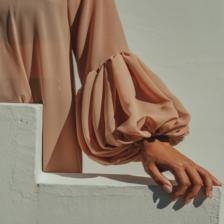
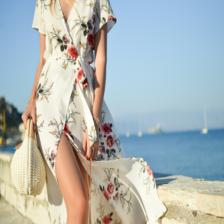
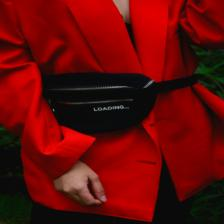
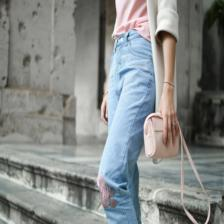

step: 33/128   lr: 0.02785   loss: 0.9284
step: 34/128   lr: 0.02764   loss: 0.9877
step: 35/128   lr: 0.02742   loss: 1.1395
step: 36/128   lr: 0.02718   loss: 1.0373
step: 37/128   lr: 0.02694   loss: 0.8063
step: 38/128   lr: 0.02669   loss: 1.0165
step: 39/128   lr: 0.02643   loss: 1.0128
step: 40/128   lr: 0.02617   loss: 1.0708
step: 41/128   lr: 0.02589   loss: 0.8603
step: 42/128   lr: 0.02561   loss: 0.9226
step: 43/128   lr: 0.02532   loss: 0.9746
step: 44/128   lr: 0.02502   loss: 0.8620
step: 45/128   lr: 0.02471   loss: 1.1110
step: 46/128   lr: 0.02440   loss: 0.6200
step: 47/128   lr: 0.02408   loss: 0.5438
step: 48/128   lr: 0.02375   loss: 0.4251
step: 49/128   lr: 0.02342   loss: 0.6043
step: 50/128   lr: 0.02308   loss: 0.7427
step: 51/128   lr: 0.02273   loss: 0.4531
step: 52/128   lr: 0.02238   loss: 0.4248
step: 53/128   lr: 0.02203   loss: 0.5905
step: 54/128   lr: 0.02166   loss: 0.7204
step: 55/128   lr: 0.02130   loss: 0.7447
step: 56/128   lr: 0.02093   loss:


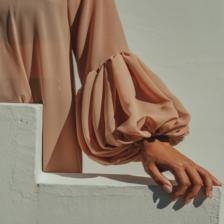
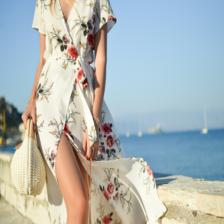
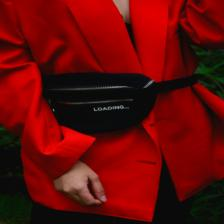
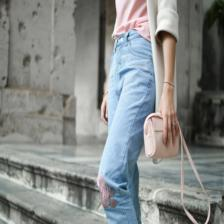

step: 65/128   lr: 0.01743   loss: 0.4279
step: 66/128   lr: 0.01702   loss: 0.4697
step: 67/128   lr: 0.01662   loss: 0.4828
step: 68/128   lr: 0.01622   loss: 0.3566
step: 69/128   lr: 0.01581   loss: 0.2299
step: 70/128   lr: 0.01541   loss: 0.2660
step: 71/128   lr: 0.01500   loss: 0.2056
step: 72/128   lr: 0.01459   loss: 0.2997
step: 73/128   lr: 0.01419   loss: 0.3636
step: 74/128   lr: 0.01378   loss: 0.3167
step: 75/128   lr: 0.01338   loss: 0.1982
step: 76/128   lr: 0.01297   loss: 0.2380
step: 77/128   lr: 0.01257   loss: 0.2491
step: 78/128   lr: 0.01217   loss: 0.3321
step: 79/128   lr: 0.01178   loss: 0.2288
step: 80/128   lr: 0.01138   loss: 0.1788
step: 81/128   lr: 0.01099   loss: 0.1072
step: 82/128   lr: 0.01060   loss: 0.1518
step: 83/128   lr: 0.01021   loss: 0.1761
step: 84/128   lr: 0.00983   loss: 0.1812
step: 85/128   lr: 0.00945   loss: 0.1789
step: 86/128   lr: 0.00907   loss: 0.1412
step: 87/128   lr: 0.00870   loss: 0.1053
step: 88/128   lr: 0.00834   loss:


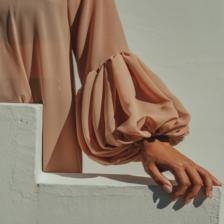
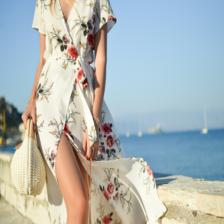
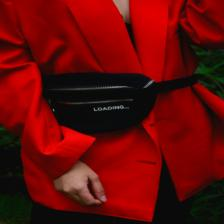
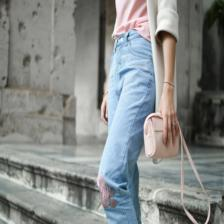

step: 97/128   lr: 0.00529   loss: 0.0791
step: 98/128   lr: 0.00498   loss: 0.0511
step: 99/128   lr: 0.00468   loss: 0.0344
step: 100/128   lr: 0.00439   loss: 0.0400
step: 101/128   lr: 0.00411   loss: 0.0279
step: 102/128   lr: 0.00383   loss: 0.0329
step: 103/128   lr: 0.00357   loss: 0.0817
step: 104/128   lr: 0.00331   loss: 0.1226
step: 105/128   lr: 0.00306   loss: 0.0527
step: 106/128   lr: 0.00282   loss: 0.0311
step: 107/128   lr: 0.00258   loss: 0.0365
step: 108/128   lr: 0.00236   loss: 0.0587
step: 109/128   lr: 0.00215   loss: 0.0445
step: 110/128   lr: 0.00194   loss: 0.0916
step: 111/128   lr: 0.00175   loss: 0.0809
step: 112/128   lr: 0.00156   loss: 0.0392
step: 113/128   lr: 0.00139   loss: 0.0352
step: 114/128   lr: 0.00122   loss: 0.0146
step: 115/128   lr: 0.00107   loss: 0.0197
step: 116/128   lr: 0.00092   loss: 0.0571
step: 117/128   lr: 0.00079   loss: 0.0127
step: 118/128   lr: 0.00066   loss: 0.0102
step: 119/128   lr: 0.00055   loss: 0.0270
step: 120/128 


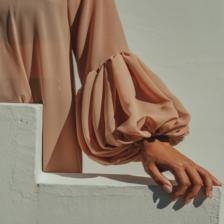
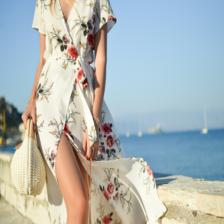
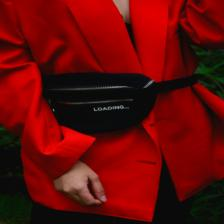
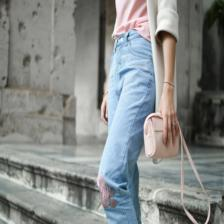

CPU times: user 2min 3s, sys: 8.48 s, total: 2min 11s
Wall time: 17min 20s


In [ ]:
# Run a short training loop with cosine learning rate schedule.
#
# Note: the first step can be quite slow on some machines (up to several minutes)
# due to XLA compilation of the jax.jit'd function.
#
%%time

BATCH_SIZE = 4
TRAIN_EXAMPLES = 512
LEARNING_RATE = 0.03

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = TRAIN_STEPS // 4

train_data_it = train_data_iterator()

sched_fn = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS+1, base=LEARNING_RATE,
    decay_type="cosine", warmup_percent=0.10)

for step in range(1, TRAIN_STEPS+1):
  # Make list of N training examples.
  examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

  # Convert list of examples into a dict of np.arrays and load onto devices.
  batch = jax.tree.map(lambda *x: np.stack(x), *examples)
  batch = big_vision.utils.reshard(batch, data_sharding)

  # Training step and report training loss
  learning_rate = sched_fn(step)
  params, loss = update_fn(params, batch, learning_rate)

  loss = jax.device_get(loss)
  print(f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}")

  if (step % EVAL_STEPS) == 0:
    print(f"Model predictions at step {step}")
    html_out = ""
    for image, caption in make_predictions(
        validation_data_iterator(), num_examples=4, batch_size=4):
      html_out += render_example(image, caption)
    display(HTML(html_out))


## Output

The validation data for this notebook consists of just 10 images. In normal code, you would likely have many more data points for validation, but for this notebook, run the following code to generate descriptions for all 10 images. After tuning the model, these descriptions should be very similar in form and content coverage to the descriptions included with the training data that you looked at earlier in this notebook.

Run the below code to generate descriptions for the validation data set.

Model predictions



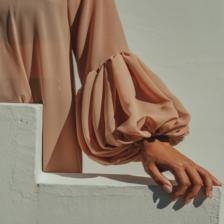
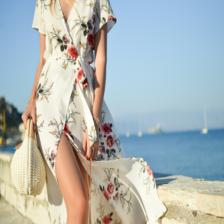
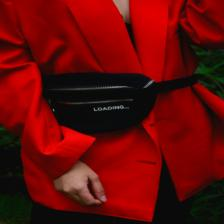
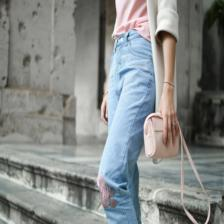
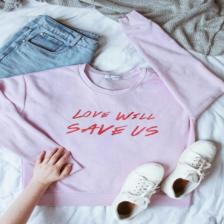
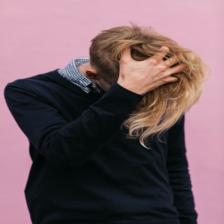
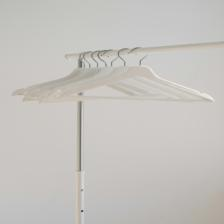
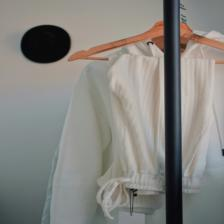
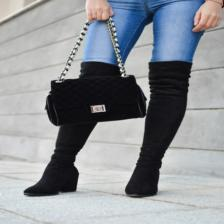
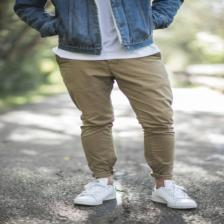

CPU times: user 1.87 s, sys: 171 ms, total: 2.04 s
Wall time: 45.7 s


In [ ]:
# The validation data consists of 10 images in a different domain than training
# data.
%%time

print("Model predictions")
html_out = ""
for image, caption in make_predictions(validation_data_iterator(), batch_size=4):
  html_out += render_example(image, caption)
display(HTML(html_out))
